In [1]:
import pymongo
import datetime
import collections

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.stats
from collections import Counter
from sklearn import cluster

In [2]:
immigration_df = pd.read_csv("data/immigration_df.csv", index_col="Unnamed: 0")
immigration_df

,Area_Code,Area,country,population_2001,births_2002,deaths_2002,natchange_2002,internal_in_2002,internal_out_2002,internal_net_2002,...,internal_out_2015,internal_net_2015,international_in_2015,international_out_2015,international_net_2015,other_change_2015,population_2015,international_in_total,international_net_total,population_change
0,E06000001,Hartlepool,E,90152,1017,1042,-25,2140,2301,-161,...,2281,-144,248,135,113,15,92493,2524,546,2438
1,E06000002,Middlesbrough,E,141233,1663,1396,267,5109,6737,-1628,...,7071,-887,1250,450,800,12,139509,15883,8376,-2114
2,E06000003,Redcar and Cleveland,E,139159,1336,1523,-187,3951,4259,-308,...,4019,195,202,109,93,25,135275,3501,40,-4117
3,E06000004,Stockton-on-Tees,E,183795,1938,1719,219,6269,5531,738,...,6659,-217,994,557,437,-23,194803,9454,1953,10324
4,E06000005,Darlington,E,97894,1102,1173,-71,3815,3521,294,...,3779,-36,347,407,-60,19,105389,4671,304,7473
5,E06000006,Halton,E,118559,1389,1230,159,3253,3678,-425,...,3646,-176,249,217,32,16,126528,2596,-615,7795
6,E06000007,Warrington,E,191202,2149,1836,313,6517,6412,105,...,6650,477,1175,722,453,-13,207695,11838,3905,15226
7,E06000008,Blackburn with Darwen,E,138453,2126,1383,743,4792,5665,-873,...,5631,-877,778,673,105,-7,146846,10904,3822,8290
8,E06000009,Blackpool,E,142270,1417,2135,-718,9023,8333,690,...,8241,-761,565,561,4,10,139578,9475,444,-1769
9,E06000010,"Kingston upon Hull, City of",E,249913,2814,2584,230,9009,10690,-1681,...,9815,-1100,2718,1467,1251,261,258995,37535,21669,7797


# Investigations based on the grouping by country

In [3]:
# Let's group the dataframe based on the country excluding the general row for northern ireland
grouped_df = immigration_df[immigration_df["Area"] !=  "Northern Ireland"].groupby("country")

In [4]:
grouped_data = pd.DataFrame(grouped_df.sum()[["population_2014", "international_in_total","international_net_total","population_change"]])
grouped_data = grouped_data.reset_index()
grouped_data

,country,population_2014,international_in_total,international_net_total,population_change
0,E,54316618,6691100,2722988,4866872
1,N,1840498,168493,33365,151660
2,S,5347600,489200,155300,283400
3,W,3092036,180314,50679,181804


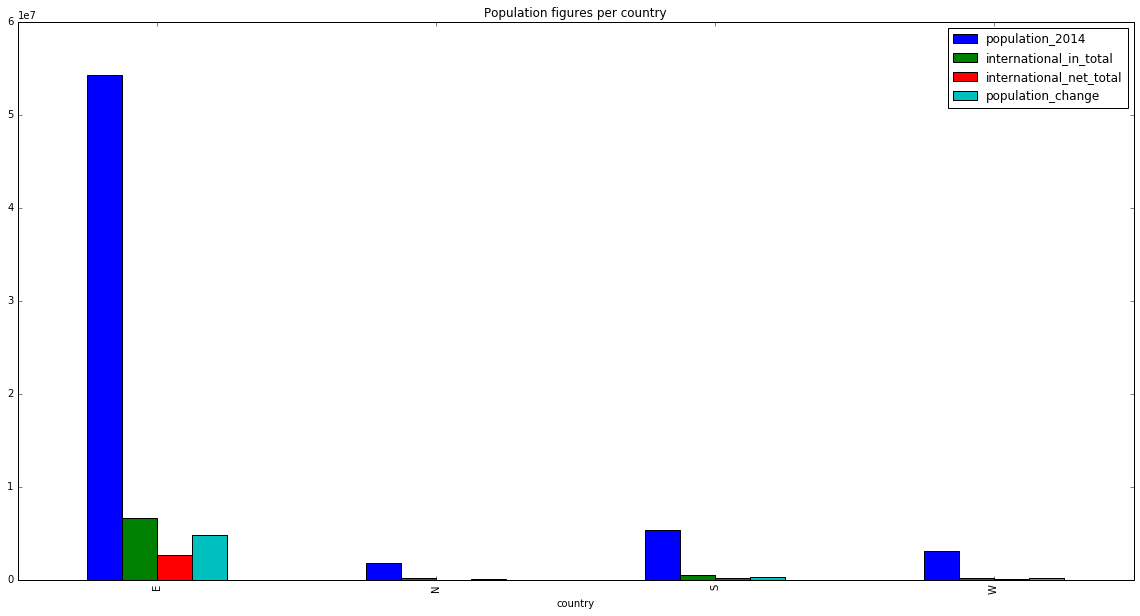

In [5]:
grouped_data.plot.bar(x="country", figsize=(20,10), title= "Population figures per country")

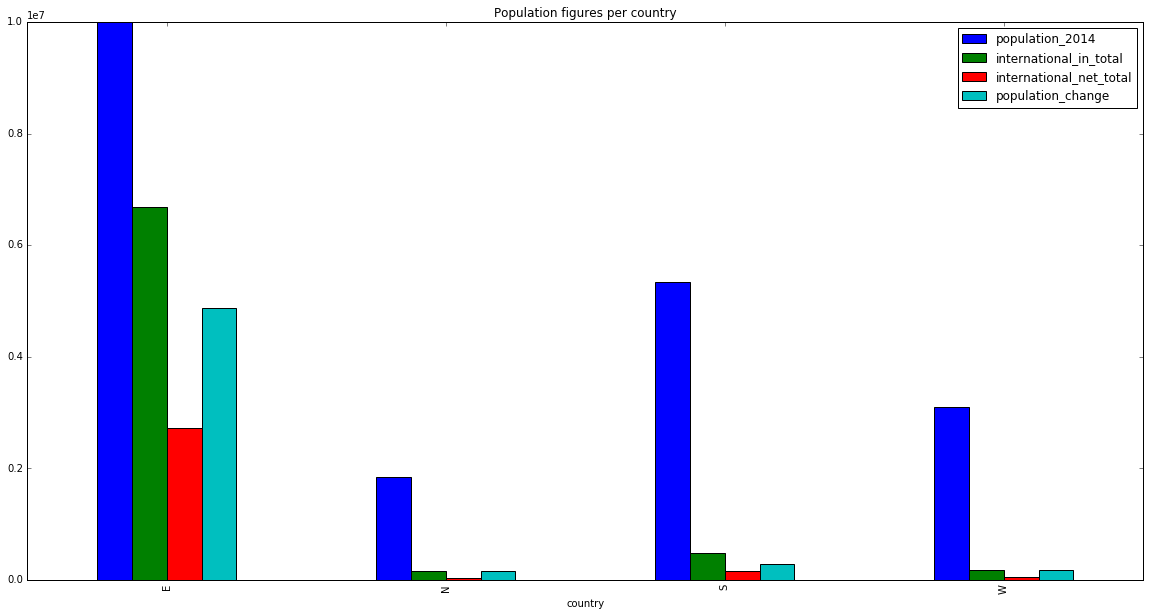

In [6]:
grouped_data.plot.bar(x="country", figsize=(20,10), title= "Population figures per country", ylim=(0,10000000))

Let's now investigate which country has received more immigration during the last 13 years considering the relative immigration figures against their absolute population.

In [7]:
grouped_data["relative_in_immigration"] = 0
grouped_data["relative_net_immigration"] = 0

In [8]:
def calculate_relative_in (row):
    return ((row["international_in_total"] * 100) / (row["population_2014"]))

def calculate_relative_net (row):
    return ((row["international_net_total"] * 100) / (row["population_2014"]))

In [9]:
grouped_data["relative_in_immigration"] = grouped_data.apply(calculate_relative_in, axis=1)
grouped_data["relative_net_immigration"] = grouped_data.apply(calculate_relative_net, axis=1)
grouped_data

,country,population_2014,international_in_total,international_net_total,population_change,relative_in_immigration,relative_net_immigration
0,E,54316618,6691100,2722988,4866872,12.318698,5.013177
1,N,1840498,168493,33365,151660,9.154751,1.812825
2,S,5347600,489200,155300,283400,9.148029,2.904107
3,W,3092036,180314,50679,181804,5.831562,1.639017


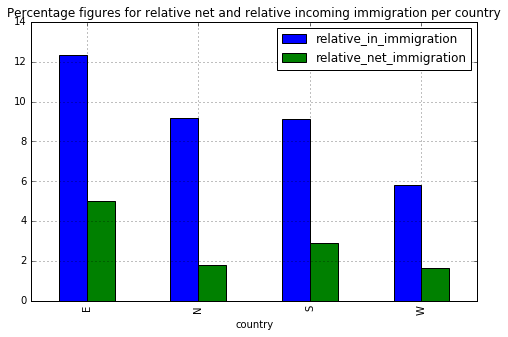

In [10]:
# Northern Ireland high figures can be explained for its proximity with Ireland
grouped_data.plot.bar(x="country", y=["relative_in_immigration","relative_net_immigration"], grid=True, 
                      title="Percentage figures for relative net and relative incoming immigration per country",
                     figsize=(8,5))

As we can see, England is both the country with the highest population figures in the UK and the one with the highest relative net and incoming immigration figures. 
Second important observation:
Despite Scotland having almost 2.5 times the population of Northern Ireland, their relative incoming immigration figures are virtually equal. However, Scotland doubles the relative net immigration figures when compared to Northern Ireland: More international immigration stays in Scotland than in Northern Ireland. This can be further investigated.

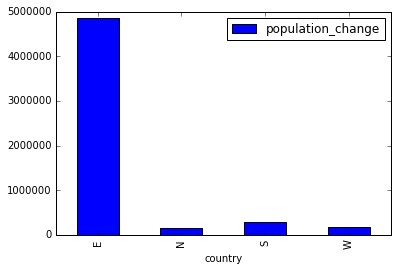

In [11]:
grouped_data.plot.bar(x="country", y="population_change")

Let's have a look at the relative population change in each region.

In [12]:
def calculate_relative_population (row):
    return ((row["population_change"] * 100) / (row["population_2014"]))

In [13]:
grouped_data["relative_population_change"] = grouped_data.apply(calculate_relative_population, axis=1)
grouped_data

,country,population_2014,international_in_total,international_net_total,population_change,relative_in_immigration,relative_net_immigration,relative_population_change
0,E,54316618,6691100,2722988,4866872,12.318698,5.013177,8.960190
1,N,1840498,168493,33365,151660,9.154751,1.812825,8.240161
2,S,5347600,489200,155300,283400,9.148029,2.904107,5.299574
3,W,3092036,180314,50679,181804,5.831562,1.639017,5.879750


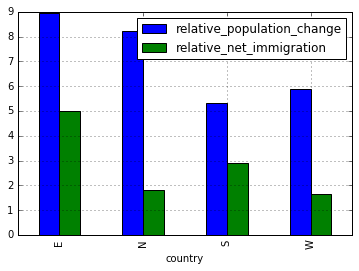

In [14]:
grouped_data.plot.bar(x="country", y=["relative_population_change", "relative_net_immigration"], grid=True)

This plot shows us what percentage of population change is caused by international immigration. However, we can investigate this further if we relate this two figures in order to find out the exact percentage of population change caused by immigration.

In [15]:
grouped_data

,country,population_2014,international_in_total,international_net_total,population_change,relative_in_immigration,relative_net_immigration,relative_population_change
0,E,54316618,6691100,2722988,4866872,12.318698,5.013177,8.960190
1,N,1840498,168493,33365,151660,9.154751,1.812825,8.240161
2,S,5347600,489200,155300,283400,9.148029,2.904107,5.299574
3,W,3092036,180314,50679,181804,5.831562,1.639017,5.879750


In [16]:
def calculate_relative_immigration_population_change (row):
    return ((row["relative_net_immigration"] * 100) / (row["relative_population_change"]))

In [17]:
grouped_data["relative_immigration_over_population_change"] = grouped_data.apply(calculate_relative_immigration_population_change,axis=1)
grouped_data

,country,population_2014,international_in_total,international_net_total,population_change,relative_in_immigration,relative_net_immigration,relative_population_change,relative_immigration_over_population_change
0,E,54316618,6691100,2722988,4866872,12.318698,5.013177,8.960190,55.949448
1,N,1840498,168493,33365,151660,9.154751,1.812825,8.240161,21.999868
2,S,5347600,489200,155300,283400,9.148029,2.904107,5.299574,54.798871
3,W,3092036,180314,50679,181804,5.831562,1.639017,5.879750,27.875624


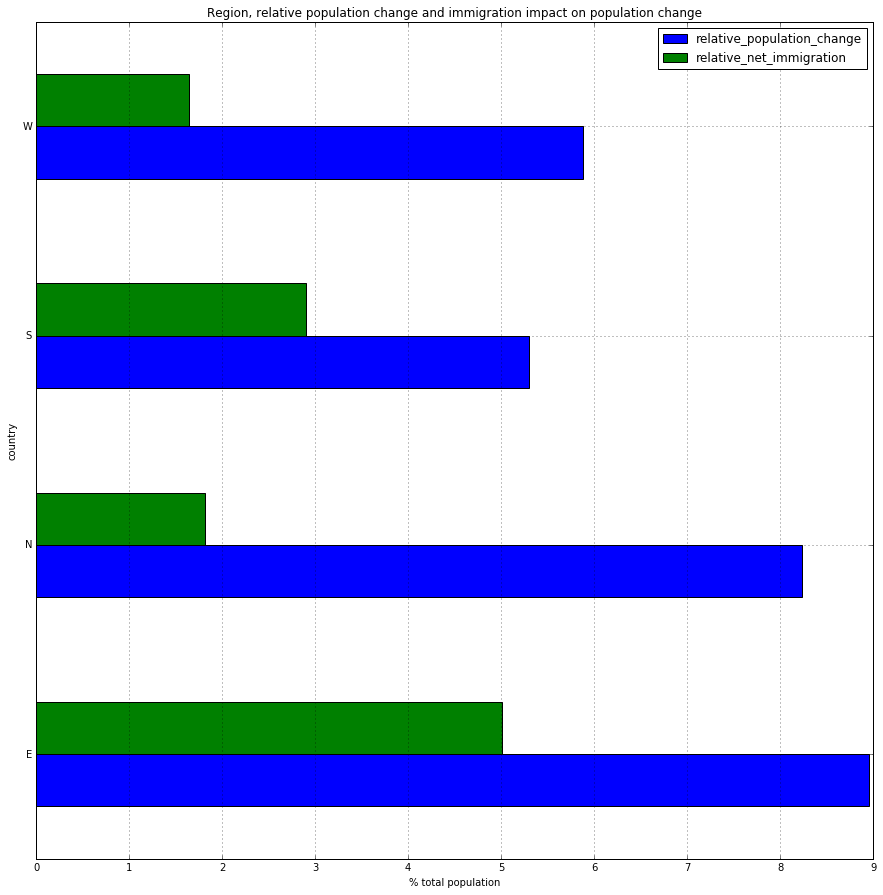

In [18]:
grouped_data.plot.barh(x="country",y=["relative_population_change","relative_net_immigration"],
                      figsize=(15,15), grid=True,
                      sort_columns=True,title="Region, relative population change and immigration impact on population change")
plt.xlabel("% total population")

From the previous plot one can see than even when the relative population change of Norhtern Ireland is smaller than the Scotish one, a higher proportion of that change is provoked bcaused by international immigration. Actually, Northern Ireland figures on this issue are quite similar to England ones.

# Investigating areas without being grouped by country

In [19]:
immigration_df = immigration_df[["Area", "country", "population_2014", "international_in_total", "international_net_total","population_change"]].copy()

In [20]:
immigration_df[immigration_df["population_2014"] > 500000]

,Area,country,population_2014,international_in_total,international_net_total,population_change
46,County Durham,E,517773,25108,9714,24095
50,Cornwall,E,545335,25061,1276,45398
259,Manchester,E,520215,160894,59792,97300
275,Sheffield,E,563749,86636,46500,50647
280,Birmingham,E,1101360,180449,82969,116718
287,Bradford,E,528155,64229,36477,57402
290,Leeds,E,766399,124507,57829,50790
351,Glasgow City,S,599640,114271,43086,20930
391,Northern Ireland,N,1840498,168493,33365,151660


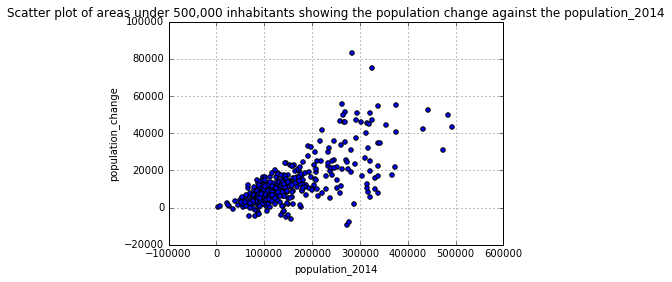

In [21]:
plt.figure()
plt.scatter(immigration_df[immigration_df["population_2014"] < 500000] ["population_2014"], 
            immigration_df[immigration_df["population_2014"] < 500000] ["population_change"])

plt.title("Scatter plot of areas under 500,000 inhabitants showing the population change against the population_2014")

plt.xlabel("population_2014")
plt.ylabel("population_change")
plt.grid(True)

# The reason behind delimiting the plot to the cities under 500,000 inhabitant is to eliminate some outliers in order to 
# appreciate the patter better.

From the plot it seems that the cities follow a quite expectable trend in which the most populated cities are the ones receiving more population. We can confirm this observation by performing Pearson's R2 test. 

In [22]:
scipy.stats.pearsonr(immigration_df['population_2014'],
            immigration_df['population_change'])

(0.80534890755494792, 1.3616192892025488e-90)

Indeed, the 0.80 value obtained through Pearsons confirmed this. It may seems obvious, but it confirms statistically that the biggest cities are growing faster than the small ones.

In [23]:
immigration_df

,Area,country,population_2014,international_in_total,international_net_total,population_change
0,Hartlepool,E,92590,2524,546,2438
1,Middlesbrough,E,139119,15883,8376,-2114
2,Redcar and Cleveland,E,135042,3501,40,-4117
3,Stockton-on-Tees,E,194119,9454,1953,10324
4,Darlington,E,105367,4671,304,7473
5,Halton,E,126354,2596,-615,7795
6,Warrington,E,206428,11838,3905,15226
7,Blackburn with Darwen,E,146743,10904,3822,8290
8,Blackpool,E,140501,9475,444,-1769
9,"Kingston upon Hull, City of",E,257710,37535,21669,7797


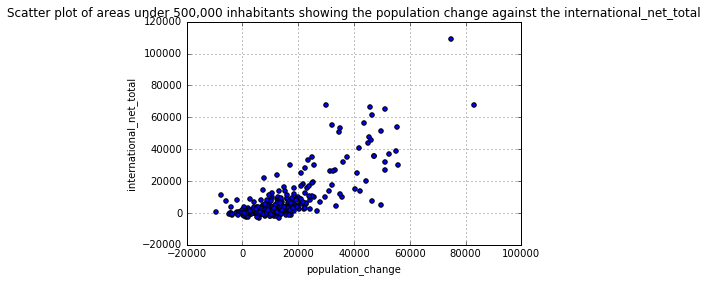

In [24]:
plt.figure()
plt.scatter(immigration_df[immigration_df["population_2014"] < 500000] ["population_change"], 
            immigration_df[immigration_df["population_2014"] < 500000] ["international_net_total"])

plt.title("Scatter plot of areas under 500,000 inhabitants showing the population change against the international_net_total")
plt.xlabel("population_change")
plt.ylabel("international_net_total")
plt.grid(True)

# The reason behind delimiting the plot to the cities under 500,000 inhabitant is to eliminate some outliers in order to 
# appreciate the patter better.

We obtain a similar patter when looking at the internationa_net_immigration against the population change: areas with a higher growing rate receive more net immigration.

In [25]:
scipy.stats.pearsonr(immigration_df['international_net_total'],
            immigration_df['population_change'])

(0.77268542371727511, 5.5319603299266534e-79)